In [1]:
# 1加载必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [2]:
# 2 定义超参数
BATCH_SIZE = 16 # 每批处理的数据
DEVICE = torch.device("cuda" if torch.cuda.is_available() else"cpu") # 是否GPU还是CPU训练
EPOCHS = 10 # 训练数据集的轮次 MNIST数据集 包含6w个训练样本， 训练十次就是 60w

In [3]:
# 3 构建pipeline， 对图像做处理
pipeline = transforms.Compose([
    transforms.ToTensor(), #将图片转换成tensor
    transforms.Normalize((0.1307,),(0.3081,)) #正则化：降低模型复杂度
])

In [4]:
# 4下载、加载数据
from torch.utils.data import DataLoader

#下载数据集
train_set = datasets.MNIST("data", train = True, download = True, transform = pipeline)

test_set = datasets.MNIST("data", train = False, download = True, transform = pipeline)

#加载数据集
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle = True)

In [5]:
#插入代码，显示MNIST中的图片
with open("./data/MNIST/raw/train-images-idx3-ubyte","rb") as f:
    file = f.read()
imagel = [int(str(item).encode('ascii'), 16) for item in file[16 : 16+784]]
print(imagel)



[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 24, 24, 24, 294, 310, 373, 38, 358, 597, 583, 295, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 54, 148, 340, 368, 595, 595, 595, 595, 595, 549, 370, 595, 578, 405, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 568, 595, 595, 595, 595, 595, 595, 595, 595, 593, 147, 130, 130, 86, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 537, 595, 595, 595, 595, 595, 408, 386, 583, 577, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 342, 263, 595, 595, 517, 17, 0, 67, 340, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 1, 340, 595, 1

In [6]:
import cv2
import numpy as np
imagel = file[16:16 + 784]

# 将字节数据直接转换为 np.uint8 类型的 NumPy 数组
imagel_np = np.frombuffer(imagel, dtype=np.uint8).reshape(28, 28, 1)

# 打印数组的形状
print(imagel_np.shape)
cv2.imwrite("digit.jpg", imagel_np)

(28, 28, 1)


True

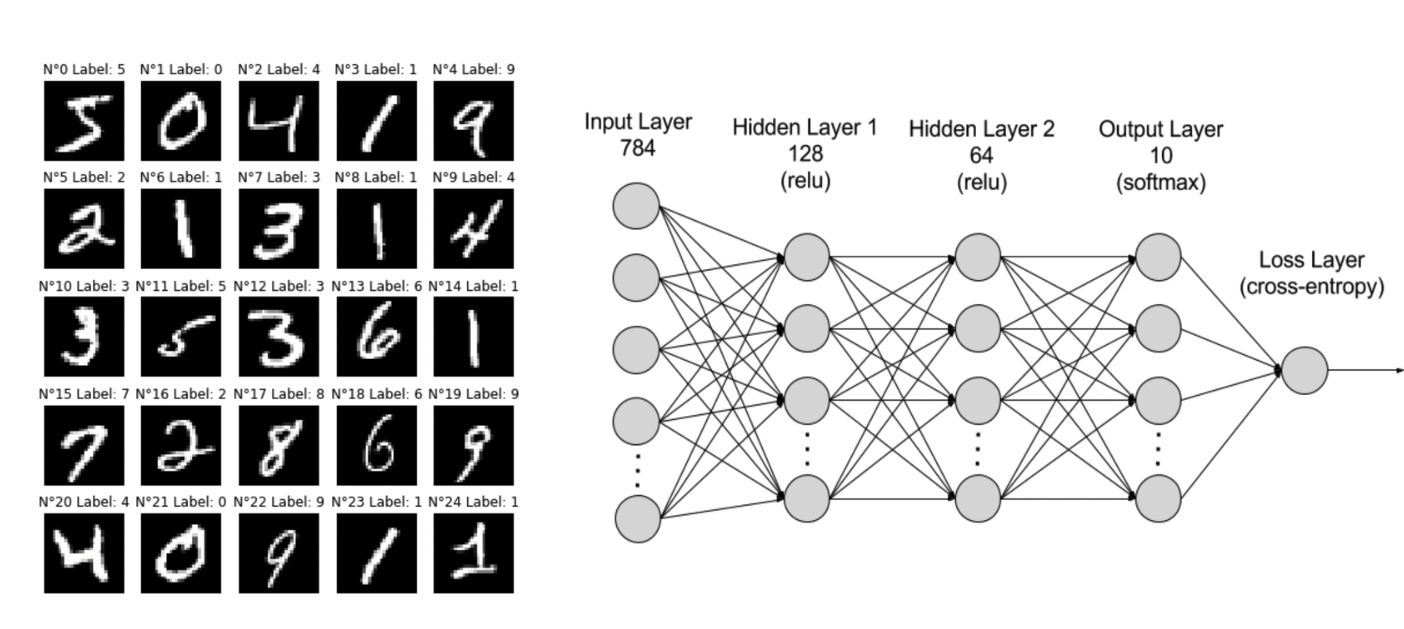


In [7]:
# 5 构建网络模型
class Digit(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) #1:灰度图片通道， 10：输出通道 5：KERNEL
        self.conv2 = nn.Conv2d(10, 20, 3) #10:输入通道 20：输出通道 3：Kernel
        self.fc1 = nn.Linear(20*10*10, 500)# 20*10*10:输入通道 500：输出通道
        self.fc2 = nn.Linear(500, 10) # 500:输入通道， 10：输出通道

    def forward(self,x):
        input_size = x.size(0) #batch_size x 1 x 28 x 28
        x = self.conv1(x) #输入：batch * 1* 28*28, 输出：batch*10 *24*24（28-5+1=24）
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = x.view(input_size, -1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        output = F.log_softmax(x, dim = 1)

        return output

In [8]:
# 6 定义优化器
model = Digit().to(DEVICE)
optimizer = optim.Adam(model.parameters())


In [9]:
# 7 定义训练方法
def train_model(model, device, train_loader, optimizer,epoch):
    #模型训练
    model.train()
    for batch_index,(data ,target) in enumerate(train_loader):
        #部署到DEVICE上去
        data, target = data.to(device), target.to(device)
        #梯度初始化为0
        optimizer.zero_grad()
        #训练后的结果
        output = model(data)
        #计算损失
        loss =  F.cross_entropy(output, target)
        #反向传播
        loss.backward()
        optimizer.step()
        if batch_index % 3000 == 0:
            print("Train Epoch : {} \t loss: {: 6f}".format(epoch, loss.item()))

In [10]:
# 8 定义测试方法
def test_model(model, device, test_loader):
    #模型验证
    model.eval()
    #正确率
    correct = 0.0
    #测试损失
    test_loss = 0.0
    with torch.no_grad():#不会计算梯度，也不会进行反向传播
        for data, target in test_loader:
            #部署到device上
            data, target = data.to(device), target.to(device)
            #测试数据
            output = model(data)
            #计算测试损失
            test_loss += F.cross_entropy(output, target).item()
            # 计算概率值最大的下标
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        print("Test-Average loss : {:.4f}, Accuracy : {:.3f}\n".format(
            test_loss, 100.0 * correct / len(test_loader.dataset)))
        

In [11]:
# 9 调用方法 7 和 8
for epoch in range(1, EPOCHS + 1):
    train_model(model, DEVICE, train_loader, optimizer, epoch)
    test_model(model,DEVICE, test_loader)

Train Epoch : 1 	 loss:  2.275707
Train Epoch : 1 	 loss:  0.234355
Test-Average loss : 0.0029, Accuracy : 98.370

Train Epoch : 2 	 loss:  0.038245
Train Epoch : 2 	 loss:  0.000542
Test-Average loss : 0.0031, Accuracy : 98.470

Train Epoch : 3 	 loss:  0.008037
Train Epoch : 3 	 loss:  0.000589
Test-Average loss : 0.0022, Accuracy : 99.040

Train Epoch : 4 	 loss:  0.009512
Train Epoch : 4 	 loss:  0.016083
Test-Average loss : 0.0028, Accuracy : 98.840

Train Epoch : 5 	 loss:  0.000069
Train Epoch : 5 	 loss:  0.104588
Test-Average loss : 0.0035, Accuracy : 98.680

Train Epoch : 6 	 loss:  0.000248
Train Epoch : 6 	 loss:  0.000074
Test-Average loss : 0.0033, Accuracy : 98.770

Train Epoch : 7 	 loss:  0.000010
Train Epoch : 7 	 loss:  0.000374
Test-Average loss : 0.0026, Accuracy : 99.090

Train Epoch : 8 	 loss:  0.012330
Train Epoch : 8 	 loss:  0.153714
Test-Average loss : 0.0045, Accuracy : 98.720

Train Epoch : 9 	 loss:  0.197759
Train Epoch : 9 	 loss:  0.266052
Test-Average